# Basic CNN with Fashion mnist

['Introduction to CNN Keras - Acc 0.997 (top 8%)'](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)의 코드를 바탕으로 fahsion mnist dataset을 학습시켜보도록 하겠습니다.

Fashion mnist data : https://github.com/zalandoresearch/fashion-mnist

## 1. Setup

In [1]:
from __future__ import absolute_import, print_function, division

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools #for confusion matrix
%matplotlib inline

from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

C:\Users\home\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Set the random seed
random_seed = 200

## 2. Data preparation

### 2.1 Load the dataset

`keras.datasets.fashion_mnist`로 dataset을 불러온다.<br>
60000장의 train_image와 10000장의 test_images로 구성되어 있다.

In [3]:
(train_img, train_label), (test_img, test_label) = keras.datasets.fashion_mnist.load_data()

In [4]:
print(train_img.shape, test_img.shape)
print(train_label[1])

(60000, 28, 28) (10000, 28, 28)


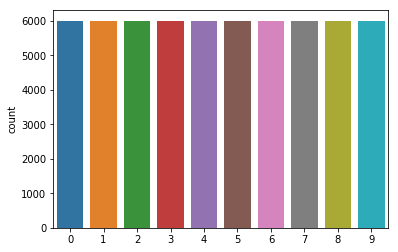

In [9]:
train_label.sum(axis=0)
g=sns.countplot(train_label)

### 2.2 Data Preprocessing

불러온 image data는 0~255 사이의 숫자로 표시되어 있는데, 이를 0~1 scale로 변환시켜주고, RGB channel을 나타내기 위해 마지막에 새로운 dimension을 추가한다.<br>
label data는 0~9 class number로 되어있다. 이를 one-hot vector 형태로 바꿔준다.

In [11]:
train_img = train_img.reshape(-1,28,28,1) / 255
test_img = test_img.reshape(-1,28,28,1) /255

train_label = keras.utils.to_categorical(train_label, num_classes=10)
test_label = keras.utils.to_categorical(test_label, num_classes=10)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Split the train and the validation set for the fitting
train_img, val_img, train_label, val_label = train_test_split(train_img, train_label, test_size = 0.1,
                                                  random_state=random_seed)

Validation data는 `model.fit`에서 validation split rate를 설정해서 나눌수도 있지만, 두 개의 모델을 training 할 때, Validation data가 고정 될 수 있도록 데이터를 나눠줄 것이다.

그럼 sample image를 확인해보자.

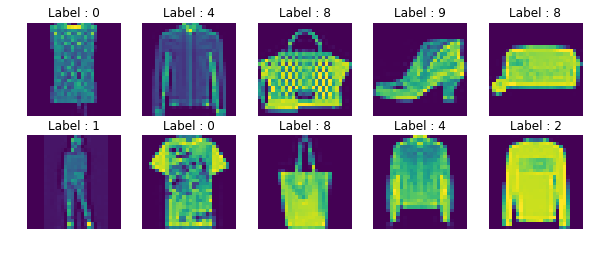

In [14]:
def plot_image(x):
    plt.figure(figsize=(10,10))
    
    for ax in range(10):
        plt.subplot(5,5, ax+1)
        plt.imshow(x[ax,:,:,0])
        plt.title("Label : {}".format(np.argmax(train_label[ax])))
        plt.axis('off')
        
plot_image(train_img)

## 3.CNN

### 3.1 Define the model

Keras.Sequential API를 이용해서 Model를 정의한다. 모델는 기존 코드에서 사용된 구조를 사용할 것이다.

In [15]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=[5,5], padding='SAME',
                     activation='relu', input_shape=(28,28,1)))
    model.add(Conv2D(filters=64, kernel_size=[5,5], padding='SAME',
                     activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    return model

In [16]:
model_1 = create_model()
model_2 = create_model()
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

### 3.2 Set the optimizer and callback

training에서 사용될 optimizer를 설정하고, `model.compile`를 정의한다.<br>
optimizer는 'Adam'과 'RMSprop' 두가지를 설정하고 각각의 학습 결과를 살펴볼 것이다.

Loss는 'categorical_crossentropy', metrics는 'accuracy로 정의한다.

In [17]:
optimizer_a = Adam(lr=0.001, epsilon=1e-08)
optimizer_R = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [18]:
#Using 'RMSprop optimizer'
model_1.compile(optimizer=optimizer_R, loss='categorical_crossentropy',
             metrics=['accuracy'])

#Using 'Adam optimizer'
model_2.compile(optimizer=optimizer_a, loss='categorical_crossentropy',
             metrics=['accuracy'])

callback object를 이용해서 training간 learning rate가 변화하도록 설정하자.<br>
`keras.callbacks.ReduceLROnPlateau`를 사용하며, 기존의 코드와 동일하게 설정할 것이다.

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3,
                                           verbose=1, factor=0.5, min_lr=0.0001)

### 3.3 Data augmentation

기존의 training data에 변동을 주고 dataset을 확장시키기 위해 augmentation 과정을 거친다.<br>
`keras.preprocessing.image.ImageDataGenerator`를 이용할 것이며, 이미지 축소 및 확대, 좌우 및 상하 이동만 줄 것이다.

In [20]:
datagen = ImageDataGenerator(zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)

datagen.fit(train_img)

### 3.4 Training step

model을 학습시킨다. ImageDataGenerator를 사용할 경우, `fit_generator`을 사용하며 steps_per_epoch으로 한 epoch에서 몇 장의 augmentation image를 생성할 지 설정한다. Generator를 사용하지 않는다면, `fit`을 사용하면 된다.

In [21]:
epochs = 1 #more epcohs for training
batch_size = 86

In [22]:
model_1_hist = model_1.fit_generator(datagen.flow(train_img, train_label, batch_size=batch_size),
                                   validation_data=(val_img, val_label),
                                   steps_per_epoch= train_img.shape[0] // batch_size,
                                   epochs=epochs, verbose=1,
                                   callbacks=[learning_rate_reduction])

Epoch 1/1
627/627 [==============================] - 718s 1s/step - loss: 1.2241 - acc: 0.5375 - val_loss: 0.6379 - val_acc: 0.7603


In [6]:
model_2_hist = model_2.fit_generator(datagen.flow(train_img, train_label, batch_size=batch_size),
                                   validation_data=(val_img, val_label),
                                   steps_per_epoch= train_img.shape[0] // batch_size,
                                   epochs=epochs, verbose=1,
                                   callbacks=[learning_rate_reduction])

NameError: name 'model_2' is not defined

## 4. Evaluation

### 4.1 plot the training and validation loss

In [7]:
def plt_history(hist1, hist2):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(hist1.epoch, hist.history['loss'], label="Model(Adam) Loss")
    plt.plot(hist2.epoch, hist.history['loss'], label="Model(RMS) Loss")
    plt.ylim([0,1])
    plt.xlabel('epoch')
    plt.ylabel('Training Loss')
    plt.legend(loc='best', shadow=True)

    plt.subplot(2,1,2)
    plt.plot(hist1.epoch, hist.history['val_loss'], label="Model(Adam) Val Loss")
    plt.plot(hist2.epoch, hist.history['val_loss'], label="Model(RMS) Val Loss")
    plt.xlabel('epoch')
    plt.ylabel('Val loss')
    plt.ylim([0,1])
    plt.legend(loc='best', shadow=True)
    plt.show()
    
plt_history(model_1_hist, model_2_hist)

SyntaxError: positional argument follows keyword argument (<ipython-input-7-f0cfa470b4d5>, line 5)

### 4.2 Confusion matrix

In [23]:
#Loot at the confusion matrix
#Code is 'https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[499  13   6  41   4   2  33   0   6   0]
 [  4 524   3  17   4   0   6   0   0   0]
 [  6   1 359   2 164   2  58   0   7   0]
 [ 58  36   1 474  23   0  42   0   1   0]
 [  2   4  64  26 475   1  27   0   2   0]
 [  0   0   1   0   0 486   0  75   0  41]
 [153   5 145  20 152   1 122   0  12   0]
 [  0   0   0   0   0  30   0 525   2  69]
 [  2   3  11   1   2   3  17   2 529   0]
 [  0   0   0   0   0   6   1  18   0 569]]


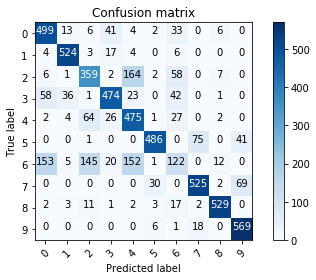

In [26]:
#Predict the value from the validation dataset, sigmoid values 
Y_pred = model_1.predict(val_img)

#Convert class number to one-hot vector, 0~ 9 class number
Y_pred_classes = np.argmax(Y_pred, axis=1)

#Convert label data class number to one-hot vector
Y_true = np.argmax(val_label, axis=1)

In [ ]:
#compile the confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
#Plot the matrix
plot_confusion_matrix(conf_matrix, classes = range(10))

### 4.3 Confirm error images

높은 loss를 보이는 10개의 image를 출력해서 확인해보자.

In [34]:
error = (Y_true != Y_pred_classes)

In [55]:
#model prediction class number
error_pred_class = Y_pred_classes[error]
#model prediction prop values 
error_prop = Y_pred[error]

#True class number
error_true_class = Y_true[error]
#True image
error_img = val_img[error]

In [176]:
#실제 class를 예측한 값과 잘못 예측한 class 값의 차이를 구하자.
error_loss_value = np.array([error_prop[i][error_pred_class[i]] - error_prop[i][error_true_class[i]]
                             for i in range(error_prop.shape[0])])

top_image = np.argsort(error_loss_value) #image number로 나타냄

six_image = top_image[-10:]

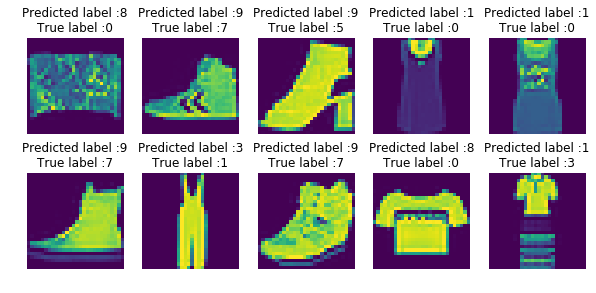

In [181]:
def plot_image_error(x):
    plt.figure(figsize=(10,12))
    ax = 1
    
    for i in x:
        plt.subplot(5,5, ax)
        plt.imshow(error_img[i,:,:,0])
        plt.title("Predicted label :{}\nTrue label :{}".format(error_pred_class[i],error_true_class[i]))
        plt.axis('off')
        ax += 1
        
plot_image_error(six_image)

### 4.4 Predict Test dataset

In [175]:
loss, acc = model_1.evaluate(test_img, test_label)

print("Test Accuarcy is : {:.2f}%".format(acc*100))

10000/10000 [==============================] - 42s 4ms/step
Test Accuarcy is : 75.10%


In [ ]:
#for Kaggle result
"""
test_pred = model_1.predict(test_img)

result = np.argmax(test_pred, axis=1)

results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)
"""